In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import dedalus.public as d3
import h5py
from scipy.interpolate import RegularGridInterpolator as RGI

plt.style.use('apj')

Ra = 1e11
Pr = 1
nu = np.sqrt(Pr/Ra)
Lx = 2
Nr = 2048
Nphi = 2*Nr

dtype = np.float64
dealias = 3/2
hires_factor = 1/dealias

coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.DiskBasis(coords, shape=(Nphi, Nr), radius=1, dealias=dealias, dtype=dtype, azimuth_library='matrix')
phi, r = dist.local_grids(basis, scales=(hires_factor*dealias, hires_factor*dealias))
phi_de, r_de = dist.local_grids(basis, scales=(dealias, dealias))


with h5py.File('dynamics_slices.h5', 'r') as f:
    T = f['tasks/T'][-1,:,:]

mask = dist.Field(name='mask', bases=basis)   
with h5py.File('../masks/moosinesq_Ra{:.1e}_{}x{}_de{:.1f}_gamma100.h5'.format(Ra, Nr,Nphi,dealias)) as f:
    mask.change_scales(dealias)
    mask['g'] = f['mask'][()]

mask_interp = RGI((phi_de.ravel(), r_de.ravel()), mask['g'], bounds_error=False, fill_value=1)

(4096, 2048) (4096, 2048) (4096, 2048)


/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gn/T/ipykernel_33970/2050600179.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  color = ax.pcolormesh(xx, yy, T, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, rasterized=True)


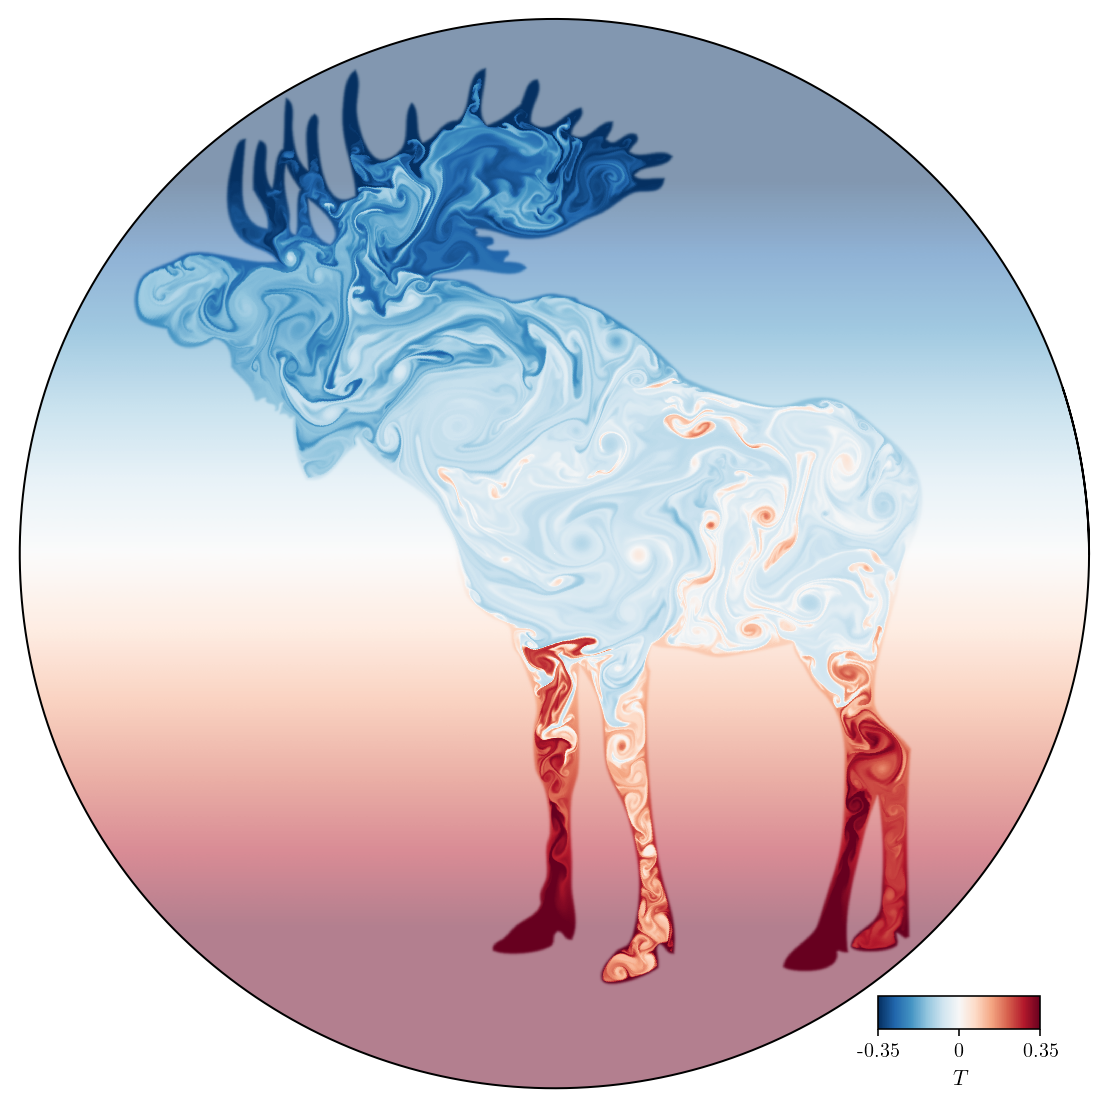

In [5]:
fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_axes([0, 0, 1, 1], polar=False)
cax = fig.add_axes([0.8, 0.06, 0.15, 0.03])
#cax2 = fig.add_axes([0.05, 0.06, 0.15, 0.03])

rr, pp = np.meshgrid(r.ravel(), phi.ravel())
xx = rr*np.cos(pp)
yy = rr*np.sin(pp)
print(xx.shape, yy.shape, T.shape)


vmin = -0.35
vmax = 0.35

color = ax.pcolormesh(xx, yy, T, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, rasterized=True)
cbar = plt.colorbar(color, cax=cax, orientation='horizontal')
cbar.set_label(r'$T$')
cbar.set_ticks((vmin, 0, vmax))
cbar.set_ticklabels(['{:.2f}'.format(vmin), '0', '{:.2f}'.format(vmax)])
ax.set_yticks([])
ax.set_xticks([])



from matplotlib.colors import ListedColormap
t_cmap = np.ones([256, 4])
t_cmap[:, 3] = np.linspace(0, 0.5, 256)
t_cmap = ListedColormap(t_cmap)

x_cartesian = np.linspace(-1, 1, int(2*Nr)+1)
y_cartesian = np.linspace(-1, 1, int(2*Nr)+1)
yy_c, xx_c = np.meshgrid(y_cartesian, x_cartesian)
rr_c = np.hypot(xx_c, yy_c)
pp_c = np.arctan2(yy_c, xx_c)
pp_c[pp_c < 0] += 2*np.pi
pmask = mask_interp((pp_c, rr_c))

#pp_c = np.ma.masked_where(rr_c > 1, pp_c)
#rr_c = np.ma.masked_where(rr_c > 1, rr_c)
#pmask = np.ma.masked_where(rr_c > 1, pmask)

color2 = ax.pcolormesh(xx_c, yy_c, pmask, shading='auto', cmap=t_cmap, vmin=0, vmax=1, rasterized=True)
phi_line = np.linspace(0, 2.1*np.pi, 1000)
ax.plot(np.cos(phi_line), np.sin(phi_line), c='k', lw=1)

#cbar = plt.colorbar(color2, cax=cax2, orientation='horizontal')
#cbar.set_label(r'$\mathcal{M}$')
#cbar.set_ticks((0, 0.5, 1))


for direction in ['left', 'right', 'bottom', 'top']:
    ax.spines[direction].set_visible(False)
    
ax.set_xlim(-1.01, 1.01)
ax.set_ylim(-1.01, 1.01)


fig.savefig('paper_figure02.png', dpi=400, bbox_inches='tight')

In [6]:
fig.savefig('paper_figure02.pdf', dpi=400, bbox_inches='tight')

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gn/T/ipykernel_33970/2918121275.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  color = ax.pcolormesh(xx, yy, T, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, rasterized=True)


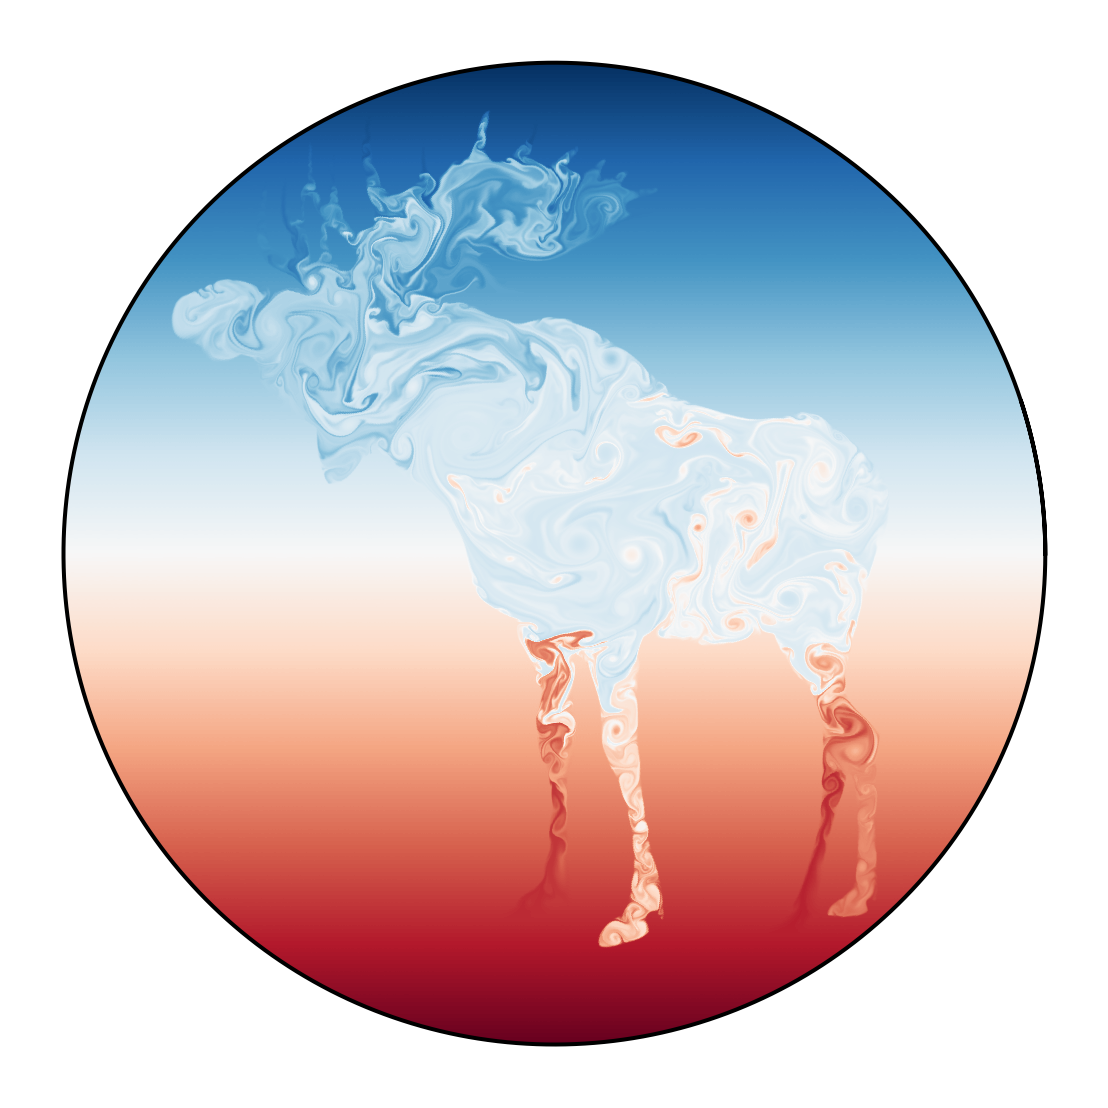

In [8]:
#moose in star
vmin = -0.5
vmax = 0.5
fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_axes([0, 0, 1, 1], polar=False)
color = ax.pcolormesh(xx, yy, T, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, rasterized=True)
ax.set_yticks([])
ax.set_xticks([])
phi_line = np.linspace(0, 2.1*np.pi, 1000)
ax.plot(np.cos(phi_line), np.sin(phi_line), c='k', lw=2)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
for direction in ['left', 'right', 'bottom', 'top']:
    ax.spines[direction].set_visible(False)
fig.savefig('moose_star.png', dpi=400, bbox_inches='tight')

